Strategy with CatBoost regression model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
from catboost import CatBoostRegressor, Pool

In [ ]:
!pip install catboost
!pip install numpy==1.24.4
!pip install optuna

In [30]:
def read_data(ticker):
    """
    Read logarithmic returns from file

    :ticker: ticker of continious futures
    """
    # You need to insert the path to the data file
    data = pd.read_csv(ticker+'.csv', index_col = 'date')
    #All datasets for this course are available at this link:
    #https://drive.google.com/drive/folders/1mhbVjuwNZGX9nmZuCxJStBmraF3HIzio?usp=sharing

    # Parse timestamps
    data.index = pd.to_datetime(data.index, format = "%Y-%m-%d %H:%M:%S")

    return data

In [31]:
data = read_data('NQ')
# data2 = read_data('YM')

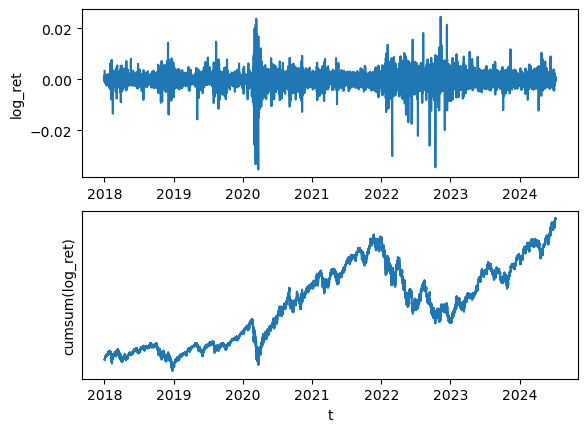

In [ ]:
# Let's draw graphs
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(data)
ax1.set_ylabel('log_ret')

ax2.plot(data.cumsum())
ax2.set_yticks([])
ax2.set_ylabel('cumsum(log_ret)')
_ = ax2.set_xlabel('t')

In [32]:
days_in_year = 365.25

def Return(rets):
    """
    Annual return estimate

    :rets: daily returns of the strategy
    """
    return np.mean(rets)*days_in_year


def Volatility(rets):
    """
    Estimation of annual volatility

    :rets: daily returns of the strategy
    """
    return np.std(rets)*np.sqrt(days_in_year)


def SharpeRatio(rets):
    """
    Estimating the annual Sharpe ratio

    :rets: daily returns of the strategy
    """
    volatility = Volatility(rets)
    if (volatility>0):
        return Return(rets)/volatility
    else:
        return float('NaN')

def statistics_calc(rets, bh, name = '_', plot = False):
    """
    Draws a graph of portfolio equity and calculates annual Sharpe ratios, profitability and volatility

    :rets: daily returns of the strategy
    """
    sharpe = SharpeRatio(rets)
    ret = Return(rets)
    vol = Volatility(rets)
    if plot:
        plt.plot(rets.cumsum(), label = 'strategy')
        plt.plot(bh.cumsum(), label = 'buy & hold')
        plt.xlabel('t')
        plt.legend()
        print('Sharpe ratio = %0.2f'%sharpe)
        print('Annual Return = %0.2f'%ret)
        print('Annual Std = %0.2f'%vol)
    return  pd.DataFrame([[sharpe, ret, vol]], columns = ['Sharpe ratio', 'Annual return', 'Volatility'], index = [name])

Features generation:

In [36]:
def make_features(data, pref = ''):
    features = pd.DataFrame(index = data.index)
    data = data.copy()

    for lag in [1, 2, 3, 5, 10]:
        features[f'lag_ret_{lag}'] = data['log_ret'].shift(lag)

    features['rolling_mean_5'] = data['log_ret'].rolling(5).mean()
    features['rolling_std_5'] = data['log_ret'].rolling(5).std()
    features['z_score'] = data['log_ret'] / (features['rolling_std_5'] + 1e-8)
    features['momentum_5'] = data['log_ret'].rolling(5).sum()
    features['log_ret_abs'] = data['log_ret'].abs()
    features['log_ret_squared'] = data['log_ret']**2
    features['sign'] = np.sign(data['log_ret'])

    # # Estimating asset volatility using double exponential moving average:
    features['absRet'] = np.abs(data['log_ret'])
    features['EmaAbsRet'] = features['absRet'].ewm(20).mean().shift(1)*np.sqrt(20)
    features['vol'] = features['EmaAbsRet'].ewm(200).mean()*np.sqrt(200)+0.000000001

    features['normalized_log_ret'] = data['log_ret']/features['vol']

    periods = (np.logspace(1.0, 3.0, num = 10)).astype(int)
    print(periods)

    for period in periods:
        features['f_'+pref+str(period)] = (np.sqrt(period)*features['normalized_log_ret'].rolling(window = period, win_type = 'hann').mean()).shift(1)
    features = features.dropna()
    return features

In [37]:
features =  make_features(data)
# features2 = make_features(data2, pref = 's')
# features2 = features2[features2.columns[np.array([name[:2] for name in features.columns]) == 'f_']]
# features = features.merge(features2, how = 'left', left_index = True, right_index = True).ffill()

[  10   16   27   46   77  129  215  359  599 1000]


In [38]:
y = features['normalized_log_ret'].values
X = features[features.columns[np.array([name[:2] for name in features.columns]) == 'f_']].values

# This is another way to specify training and training periods
train_split_idx = int(0.4*X.shape[0])
validation_split_idx = int(0.7*X.shape[0])

features_train = features[:train_split_idx].copy()

X_train = X[:train_split_idx]
y_train = y[:train_split_idx]

X_validation = X[:validation_split_idx]
y_validation = y[:validation_split_idx]
features_validation = features[:validation_split_idx].copy()

X_test = X[validation_split_idx:]
y_test = y[validation_split_idx:]

train_pool = Pool(data = X_train,
                  label = y_train)

In [41]:
features.head()

,lag_ret_1,lag_ret_2,lag_ret_3,lag_ret_5,lag_ret_10,rolling_mean_5,rolling_std_5,z_score,momentum_5,log_ret_abs,...,f_10,f_16,f_27,f_46,f_77,f_129,f_215,f_359,f_599,f_1000
date,,,,,,,,,,,,,,,,,,,,,
2018-01-05 08:40:00,-0.000091,0.000213,0.000030,0.000122,-0.000030,0.000170,0.000219,0.972153,0.000852,0.000213,...,0.038085,0.021587,0.008191,0.008859,0.032950,0.031105,0.021505,0.012782,0.027200,0.085869
2018-01-05 08:45:00,0.000213,-0.000091,0.000213,0.000487,0.000091,-0.000012,0.000265,-1.607993,-0.000061,0.000426,...,0.048034,0.028550,0.011346,0.008472,0.032655,0.031502,0.021769,0.012967,0.027006,0.085703
2018-01-05 08:50:00,-0.000426,0.000213,-0.000091,0.000030,0.000122,0.000012,0.000275,0.552890,0.000061,0.000152,...,0.052108,0.035088,0.015178,0.008553,0.032372,0.031904,0.022042,0.013155,0.026815,0.085537
2018-01-05 08:55:00,0.000152,-0.000426,0.000213,0.000213,0.000000,-0.000103,0.000291,-1.256056,-0.000517,0.000365,...,0.044770,0.040646,0.019299,0.009041,0.032091,0.032307,0.022324,0.013346,0.026627,0.085370
2018-01-05 09:00:00,-0.000365,0.000152,-0.000426,-0.000091,-0.000061,-0.000152,0.000308,-1.086960,-0.000761,0.000335,...,0.026078,0.043171,0.023213,0.009822,0.031801,0.032707,0.022612,0.013539,0.026443,0.085203


In [53]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
# study = optuna.create_study(direction = "maximize")

sampler = optuna.samplers.TPESampler(seed=10)  # Make the sampler behave in a deterministic way.
study = optuna.create_study(direction="maximize", sampler=sampler)

In [43]:
def objective(trial):

    params = {"iterations": trial.suggest_int("iterations", 10, 1000, log = True),
              "depth": trial.suggest_int("depth", 1, 10),
              'learning_rate': trial.suggest_float("learning_rate", 0.005, 0.1, log = True),
              "logging_level" :'Silent'}

    model = CatBoostRegressor(**params, loss_function = 'RMSE')

    model.fit(train_pool)

    features_validation['position'] = model.predict(X_validation)/ model.predict(X_train).std()
    features_validation['position'] = features_validation['position'].ewm(alpha = 0.1).mean()
    features_validation['position'] = features_validation['position'].fillna(0).astype(int)

    pos_limit = 1
    features_validation.loc[features_validation.index[features_validation['position']>pos_limit], 'position'] = pos_limit
    features_validation.loc[features_validation.index[features_validation['position']<-pos_limit], 'position'] = -pos_limit

    slippage = 0.00001

    eq = (data['log_ret']*features_validation['position']-slippage*features_validation['position'].diff().abs()
         ).fillna(0)[train_split_idx:].resample('1D').agg('sum')
    bh = data['log_ret'].fillna(0)[train_split_idx:].resample('1D').agg('sum')

    stats = statistics_calc(eq, bh, plot = False)

    return stats['Sharpe ratio'].iloc[0]

In [60]:
from sklearn.model_selection import TimeSeriesSplit

def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 3, 7),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0, log=True),
        "border_count": trial.suggest_int("border_count", 32, 254),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "random_strength": trial.suggest_float("random_strength", 0.0, 1.0),
        "logging_level": "Silent"
    }

    model = CatBoostRegressor(**params, loss_function = 'RMSE')
    model.fit(train_pool)

    tscv = TimeSeriesSplit(n_splits=5)  # или 5, если данных много
    sharpe_scores = []

    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]


        model = CatBoostRegressor(**params, loss_function = 'RMSE')
        model.fit(train_pool)

        features_validation['position'] = model.predict(X_validation)/ model.predict(X_train).std()
        features_validation['position'] = features_validation['position'].ewm(alpha = 0.1).mean()
        features_validation['position'] = features_validation['position'].fillna(0).astype(int)

        pos_limit = 1
        features_validation.loc[features_validation.index[features_validation['position']>pos_limit], 'position'] = pos_limit
        features_validation.loc[features_validation.index[features_validation['position']<-pos_limit], 'position'] = -pos_limit

        slippage = 0.00001

        eq = (data['log_ret']*features_validation['position']-slippage*features_validation['position'].diff().abs()
         ).fillna(0)[train_split_idx:].resample('1D').agg('sum')
        bh = data['log_ret'].fillna(0)[train_split_idx:].resample('1D').agg('sum')

        stats = statistics_calc(eq, bh, plot = False)
        sharpe_scores.append(stats['Sharpe ratio'].iloc[0])

    return np.mean(sharpe_scores)

In [ ]:
study.optimize(objective, n_trials = 50, show_progress_bar = True)

  0%|          | 0/50 [00:00<?, ?it/s]

In [45]:
optuna.visualization.plot_optimization_history(study)

In [46]:
optuna.visualization.plot_param_importances(study)

In [ ]:
study.best_params

{'iterations': 575, 'depth': 10, 'learning_rate': 0.00858238143849656}

In [ ]:
best_params = study.best_params

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0256434	test: 0.0271835	best: 0.0271835 (0)	total: 38.2ms	remaining: 21.9s
1:	learn: 0.0256424	test: 0.0271833	best: 0.0271833 (1)	total: 75.7ms	remaining: 21.7s
2:	learn: 0.0256419	test: 0.0271834	best: 0.0271833 (1)	total: 112ms	remaining: 21.3s
3:	learn: 0.0256414	test: 0.0271832	best: 0.0271832 (3)	total: 147ms	remaining: 20.9s
4:	learn: 0.0256406	test: 0.0271832	best: 0.0271832 (4)	total: 182ms	remaining: 20.7s
5:	learn: 0.0256395	test: 0.0271831	best: 0.0271831 (5)	total: 218ms	remaining: 20.6s
6:	learn: 0.0256385	test: 0.0271831	best: 0.0271831 (6)	total: 253ms	remaining: 20.5s
7:	learn: 0.0256379	test: 0.0271830	best: 0.0271830 (7)	total: 288ms	remaining: 20.4s
8:	learn: 0.0256371	test: 0.0271830	best: 0.0271830 (8)	total: 324ms	remaining: 20.4s
9:	learn: 0.0256365	test: 0.0271830	best: 0.0271830 (9)	total: 360ms	remaining: 20.3s
10:	learn: 0.0256355	test: 0.0271829	best: 0.0271829 (10)	total: 398ms	remaining: 20.4s
11:	learn: 0.0256348	test: 0.0271828	best: 0.02718

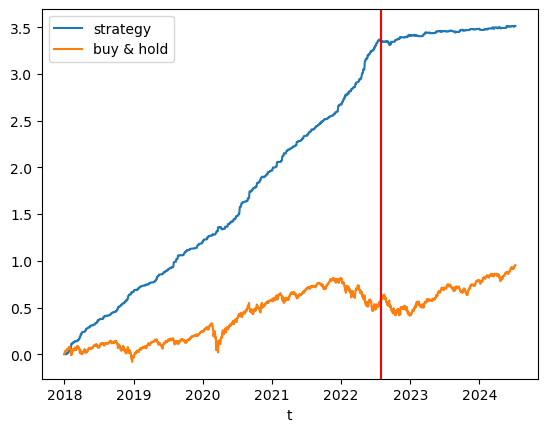

In [ ]:
model = CatBoostRegressor(**best_params, loss_function = 'RMSE')

train_pool = Pool(data = X_validation,
                  label = y_validation)

model.fit(train_pool, eval_set = (X_test, y_test), plot = True, use_best_model = False)

features['position'] = model.predict(X)/ model.predict(X_validation).std()

features['position'] = features['position'].ewm(alpha = 0.1).mean()

# We trade whole lots
features['position'] = features['position'].fillna(0).astype(int)

# Maximum position limit
pos_limit = 1
features.loc[features.index[features['position']>pos_limit], 'position'] = pos_limit
features.loc[features.index[features['position']<-pos_limit], 'position'] = -pos_limit

slippage = 0.00001

# We calculate the equity curve and convert it to a daily timeframe to calculate basic statistics
eq = (data['log_ret']*features['position']-slippage*features['position'].diff().abs()
     ).fillna(0).resample('1D').agg('sum')
bh = data['log_ret'].fillna(0).resample('1D').agg('sum')

# We calculate statistics and save the result
stats = statistics_calc(eq, bh, plot = True)

plt.axvline(x = features.index[validation_split_idx], color = 'red')

plt.savefig(r'catboost_model.png', dpi = 1200)
plt.savefig(r'catboost_model_lowq.png')


Sharpe ratio = 1.55
Annual Return = 0.08
Annual Std = 0.05


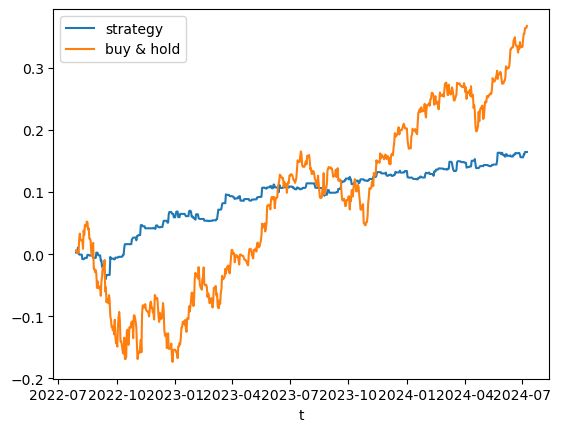

In [ ]:
# Calculate statistics on test data:
stats = statistics_calc(eq[features.index[validation_split_idx]:], bh[features.index[validation_split_idx]:], plot = True)

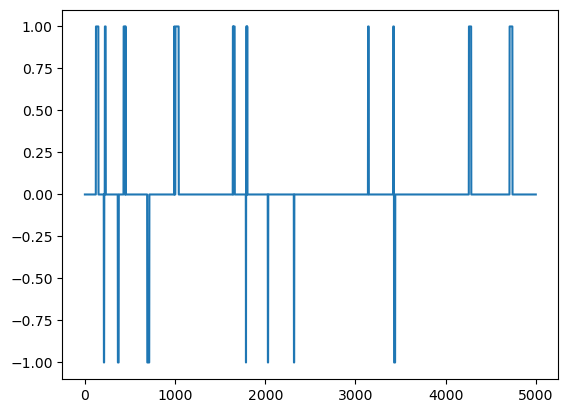

In [ ]:
plt.plot(np.arange(5000), features['position'][-5000:])

In [ ]:
# Extract the loss values from the evals_result_ dictionary
evals_result = model.get_evals_result()
train_loss = evals_result['learn']['RMSE']
test_loss = evals_result['validation']['RMSE']

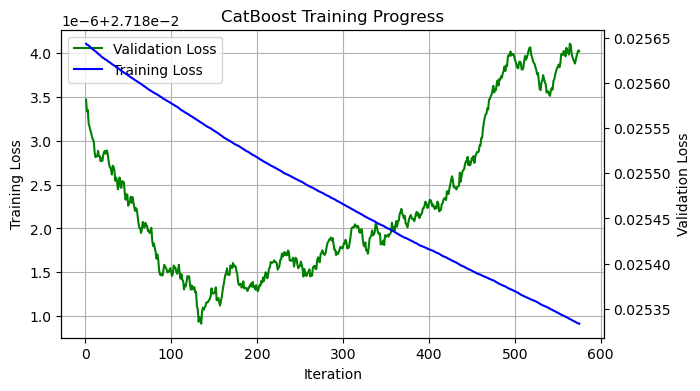

In [ ]:
# Plot the training progress
iterations = np.arange(1, len(train_loss) + 1)

fig, ax1 = plt.subplots(figsize = (7, 4) )

line1 = ax1.plot(iterations, test_loss, label = 'Validation Loss', color = 'green')

ax2 = ax1.twinx()

color = 'tab:green'
ax2.set_ylabel('Validation Loss')
line2 = ax2.plot(iterations, train_loss, label = 'Training Loss', color = 'blue')

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Training Loss')
ax1.set_title('CatBoost Training Progress')

# Make a curves list to access the parameters in the curves
lines = line1 + line2

# Add legend via axes1 or axex 2 object.
labs = [line.get_label() for line in lines]
ax1.legend(lines, labs, loc = 0)

ax1.grid()

Additional exercises and research topics:

Improve the strategy by feature engineering and using other regression models. Try other formulas for the target position calculation. Conduct detailed testing on various instruments using the walk-forward approach and stability analysis.